In [1]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime as dt

from stumpy.floss import _cac
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib import animation
from IPython.display import HTML
from scipy.signal import find_peaks
from fnmatch import fnmatch, fnmatchcase
from matplotlib.ticker import MultipleLocator,AutoMinorLocator
from math import sqrt
import os
import math

plt.rcParams['font.sans-serif']=['STSong']
plt.rcParams['figure.figsize'] = [5, 1]
plt.rcParams["figure.dpi"] = 400 # 设置分辨率

读取文件(测试)

In [4]:
root = r'D:\个人文档\data_collect\0526\csv\01-CT-H-3.csv'
dict_path = root.partition('\\csv\\')[0] + '\\segements_ste_slope\\'
file_type = root.partition('\\csv\\')[2].replace('.csv','')
df = pd.read_csv(root,header=0)

df.shape

(3552, 42)

获得所有文件的最大长度——即进一步插值长度

In [10]:
# "D:\个人文档\data_collect\0526\segements_ste_slope\01-CT-H-3-ste1-1.csv"
# seg_path = r"D:\个人文档\data_collect\0702\final\02\segments_raw\segments_raw_data"
# seg_path = r"D:\个人文档\data_collect\0702\final\02\segments_raw\segments_amplitude_raw"
seg_path = r"D:\个人文档\data_collect\0702\final\02\segments_raw"
filepath_list = []

length = 0

for dirpath, dirnames, filenames in os.walk(seg_path):
    # print(filenames)
    for filepath in filenames:
        # print(filepath)
        # if fnmatch(filepath, '01-CT-H-3-ste1*'):
        if fnmatch(filepath, '*.csv'):
            filepath_list.append(os.path.join(dirpath, filepath))
            # print(os.path.join(dirpath, filepath))
            df = pd.read_csv(os.path.join(dirpath, filepath),header=0)
            # print(df.shape)
            if len(df) > length:
                length = len(df)

length, len(filepath_list)
# filepath_list

(984, 2836)

In [4]:
filepath_list[0].replace('raw_ste', 'raw_ste_interpolated')

'D:\\个人文档\\data_collect\\0702\\final\\02\\segments_ste_raw\\02-LegCurl-30-L-1-raw_ste_interpolated4-1.csv'

In [5]:
def mkdir(path):
    # 去除首位空格
    # path=path.strip()
    # 去除尾部 \ 符号
    # path=path.rstrip("\\")
    # 判断路径是否存在
    # 存在     True
    # 不存在   False
    isExists=os.path.exists(path)
    # 判断结果
    if not isExists:
        # 如果不存在则创建目录
        # 创建目录操作函数
        os.makedirs(path) 
        print(path+' 创建成功')
        return True
    else:
        # 如果目录存在则不创建，并提示目录已存在
        print(path+' 目录已存在')
        return False

##### 一维线性插值

In [17]:
# root_interpolated = r"D:\个人文档\data_collect\0612\segments_amplitude_raw_interpolated"
root_interpolated = r"D:\个人文档\data_collect\0702\final\02\segments_raw"

In [12]:
# 1d interpolation
from scipy.interpolate import interp1d
# 多通道插值
def interpolate(df, length):
    X_interpolated = list()
    # 选取压力通道
    for label in df.columns:
        # 获取相应压力通道数据
        data = np.array(df[label])
        X = data

        # 插值到对应IMU数据长度
        len = length
        x = np.linspace(0, 1, X.shape[0])
        # 两种插值方式
        # f = interp1d(x, X, axis=0)
        f = interp1d(x, X, axis=0, kind='cubic')
        xnew = np.linspace(0, 1, length)
        ynew = f(xnew)
        X_interpolated.append(ynew)

    return np.array(X_interpolated).T

In [19]:
# 遍历，多文件插值
for root in filepath_list:
    # print(root)
    df = pd.read_csv(root,header=0)
    for label in df.columns:
        if len(df) < length:
            df_interpolate = interpolate(df, length)
            df_interpolate = pd.DataFrame(df_interpolate, columns=[label])
            # df_interpolate.to_csv(root.replace('segments_amplitude_raw', 'segments_amplitude_raw_interpolated'), index=False)
            df_interpolate.to_csv(root.replace('segments_ste_raw', 'segments_ste_raw_interpolated'), index=False)
        else:
            # df.to_csv(root.replace('segments_amplitude_raw', 'segments_amplitude_raw_interpolated'), index=False)
            df.to_csv(root.replace('segments_ste_raw', 'segments_ste_raw_interpolated'), index=False)

# df_interpolate.shape

##### 连接 + 打标签

连接

In [84]:
# D:\个人文档\data_collect\0612\segments_raw_interpolated\segments_amplitude_raw_interpolated
# '01-Lun-H-1-raw_amplitude1-1.csv'
path = r'D:\个人文档\data_collect\0612\segments_raw_interpolated\segments_amplitude_raw_interpolated'
concat_path = r'D:\个人文档\data_collect\0612\segments_raw_interpolated\segments_amplitude_raw_concat'

for i in range(1, 11):

    filepath_list = []
    flag = False

    for dirpath, dirnames, filenames in os.walk(path):
        # print(filenames)
        for filepath in filenames:
            # if fnmatch(filepath, '*01-Lun-H-1-raw_amplitude*-2.csv'):
            if fnmatch(filepath, '*01-Squat-H-2-raw_amplitude*' + str(i) + '.csv'):
                filepath_list.append(os.path.join(dirpath, filepath))
                # print(os.path.join(dirpath, filepath))
                # print(filepath)
                # print(df.shape)
                df = pd.read_csv(os.path.join(dirpath, filepath),header=0)
                # d_new = d_new.append(df)
                if flag:
                    d_new = np.append(d_new,df.to_numpy())
                else:
                    d_new = df
                    file_type = filepath.partition('-raw_amplitude')[0] + '-segment' + filepath.partition('-raw_amplitude')[2].partition('-')[2].replace('.csv','')
                    flag = True

    print(d_new.shape)

    d_new = pd.DataFrame(d_new.reshape((d_new.shape[0]//4), 4, order='F'), columns=['amplitude1', 'amplitude2', 'amplitude4', 'amplitude5'])
    d_new.to_csv(concat_path + '\\' + file_type + '.csv', index=False)

(5376,)
(5376,)
(5376,)
(5376,)
(5376,)
(5376,)
(5376,)
(5376,)
(5376,)
(5376,)


In [57]:
test = '01-Lun-H-1-raw_amplitude1-1.csv'
test.partition('-raw_amplitude'), test.partition('-raw_amplitude')[0]

(('01-Lun-H-1', '-raw_amplitude', '1-1.csv'), '01-Lun-H-1')

In [67]:
test.partition('-raw_amplitude')[2].partition('-')[2].replace('.csv','')

'1'

打标签
- 动作类型
- 完成度
- 分割片段次序
- IMU位置(通过列索引可知)

In [ ]:
root_raw = r'D:\个人文档\data_collect\0612\segments_raw_interpolated\segments_amplitude_raw_concat'
root_tag = r'D:\个人文档\data_collect\0612\segments_raw_interpolated\segments_amplitude_raw_tag'

filepath_list = []
flag = False

# dirpath    D:\个人文档\data_collect\0612\segments_raw_interpolated\segments_amplitude_raw_concat
# filepath   01-Squat-M-2-segment9.csv
# os.path.join(dirpath, filepath)      D:\个人文档\data_collect\0612\segments_raw_interpolated\segments_amplitude_raw_concat\01-Squat-M-2-segment9.csv

for dirpath, dirnames, filenames in os.walk(root_raw):
    # print(filenames)
    for filepath in filenames:
        if fnmatch(filepath, '*.csv'):
            filepath_list.append(os.path.join(dirpath, filepath))

            df = pd.read_csv(os.path.join(dirpath, filepath),header=0)

            user_id = filepath.partition('-')[0].replace('0', '')
            activity = filepath.partition('-')[2].partition('-')[0]
            level = filepath.partition('-')[2].partition('-')[2].partition('-')[0]
            num_seg = filepath.partition('segment')[2].replace('.csv','')

            df.insert(loc=df.shape[1], column='user_id', value=user_id)
            df.insert(loc=df.shape[1], column='activity', value=activity)
            df.insert(loc=df.shape[1], column='level', value=level)
            df.insert(loc=df.shape[1], column='num_seg', value=num_seg)

            # print("df.shape:{0:>6}".format(str(df.shape)))

            # df.to_csv(root_tag + '\\' + filepath.replace('csv','txt') , index=False, sep='\t')
            df.to_csv(root_tag + '\\' + filepath , index=False)

In [22]:
path = '01-Squat-M-2-segment9.csv'

# path.partition('-') # ('01', '-', 'Squat-M-2-segment9.csv')
id = path.partition('-')[0].replace('0', '')
print('id:{}'.format(id))
type = path.partition('-')[2].partition('-')[0]
print('type:{}'.format(type))
level = path.partition('-')[2].partition('-')[2].partition('-')[0]
print('level:{}'.format(level))
num_seg = path.partition('segment')[2].replace('.csv','')
print('num_seg:{}'.format(num_seg))

id:1
type:Squat
level:M
num_seg:9


In [43]:
flag = False
count = 0

for dirpath, dirnames, filenames in os.walk(root_tag):
    # print(filenames)
    for filepath in filenames:
        if fnmatch(filepath, '*.csv'):
            count += 1
            filepath_list.append(os.path.join(dirpath, filepath))

            df = pd.read_csv(os.path.join(dirpath, filepath),header=0)

            if flag:
                d_new = pd.concat([d_new, df])
            else:
                d_new = df.copy()
                flag = True
                print(df.shape)

print(count)
print(d_new.shape)
# d_new = pd.DataFrame(d_new.reshape((d_new.shape[0]//8), 8, order='F'), 
# columns=['amplitude1', 'amplitude2', 'amplitude4', 'amplitude5', 'user_id', 'activity', 'level', 'num_seg'])

(1344, 8)
120
(161280, 8)


In [31]:
df.shape, d_new.shape

((1344, 8), (161280, 8))

In [32]:
d_new.head(2)

,amplitude1,amplitude2,amplitude4,amplitude5,user_id,activity,level,num_seg
0,0.010271,0.008088,0.004984,0.014723,0.013649,0.006672,0.009062,0.003703
1,0.009155,0.009208,0.005399,0.0058,0.006296,0.008178,0.006727,0.010401


##### 运动强度 - 短时能量最大值

In [33]:
ste_path = r'D:\个人文档\data_collect\0612\segments_ste_raw'

flag = False
count = 0
filepath_list = []
period_list = []

for dirpath, dirnames, filenames in os.walk(ste_path):
    # print(filenames)
    for filepath in filenames:
        if fnmatch(filepath, '01-Lun-H-1-raw_ste1*.csv'):
            count += 1
            filepath_list.append(os.path.join(dirpath, filepath))

            df = pd.read_csv(os.path.join(dirpath, filepath),header=0)
            period_list.append(len(df))

            if flag:
                d_new = np.append(d_new,df['02-A-ste'].to_numpy())
            else:
                d_new = df['02-A-ste'].to_numpy()
                flag = True
                print(df.shape)

count, d_new.shape, df.shape

(17, 1)


(10, (169,), (16, 1))

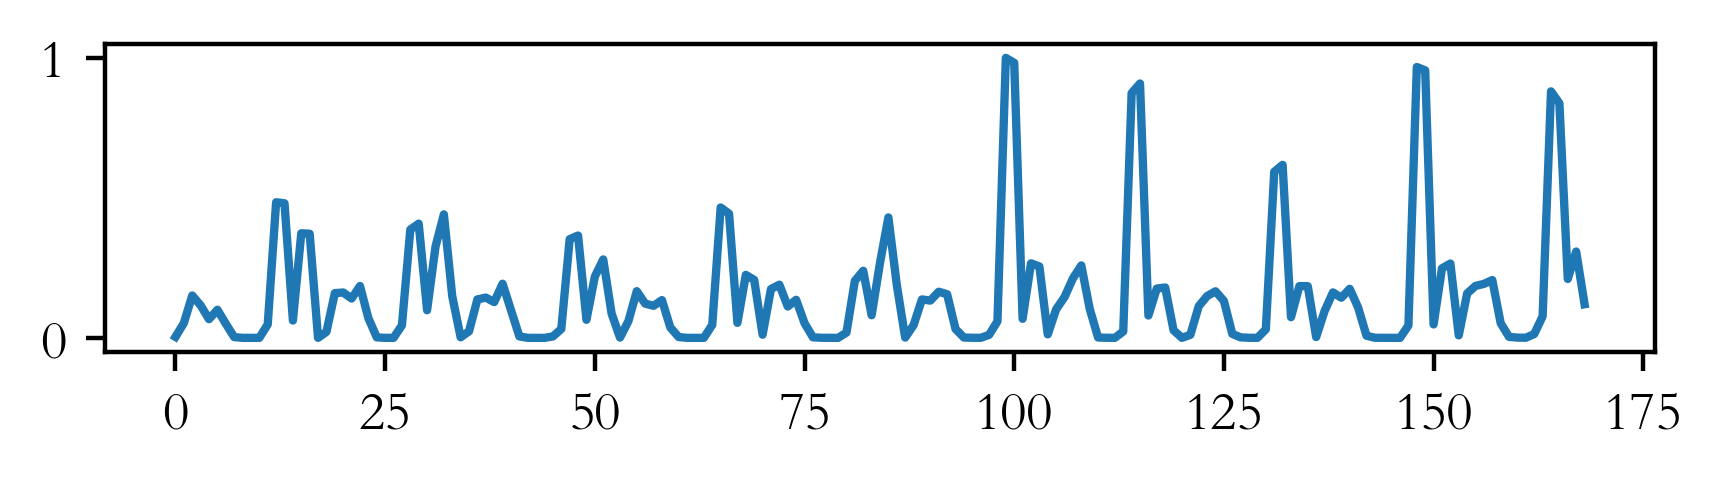

In [35]:
plt.rcParams['figure.figsize'] = [5, 1]
plt.plot(d_new)

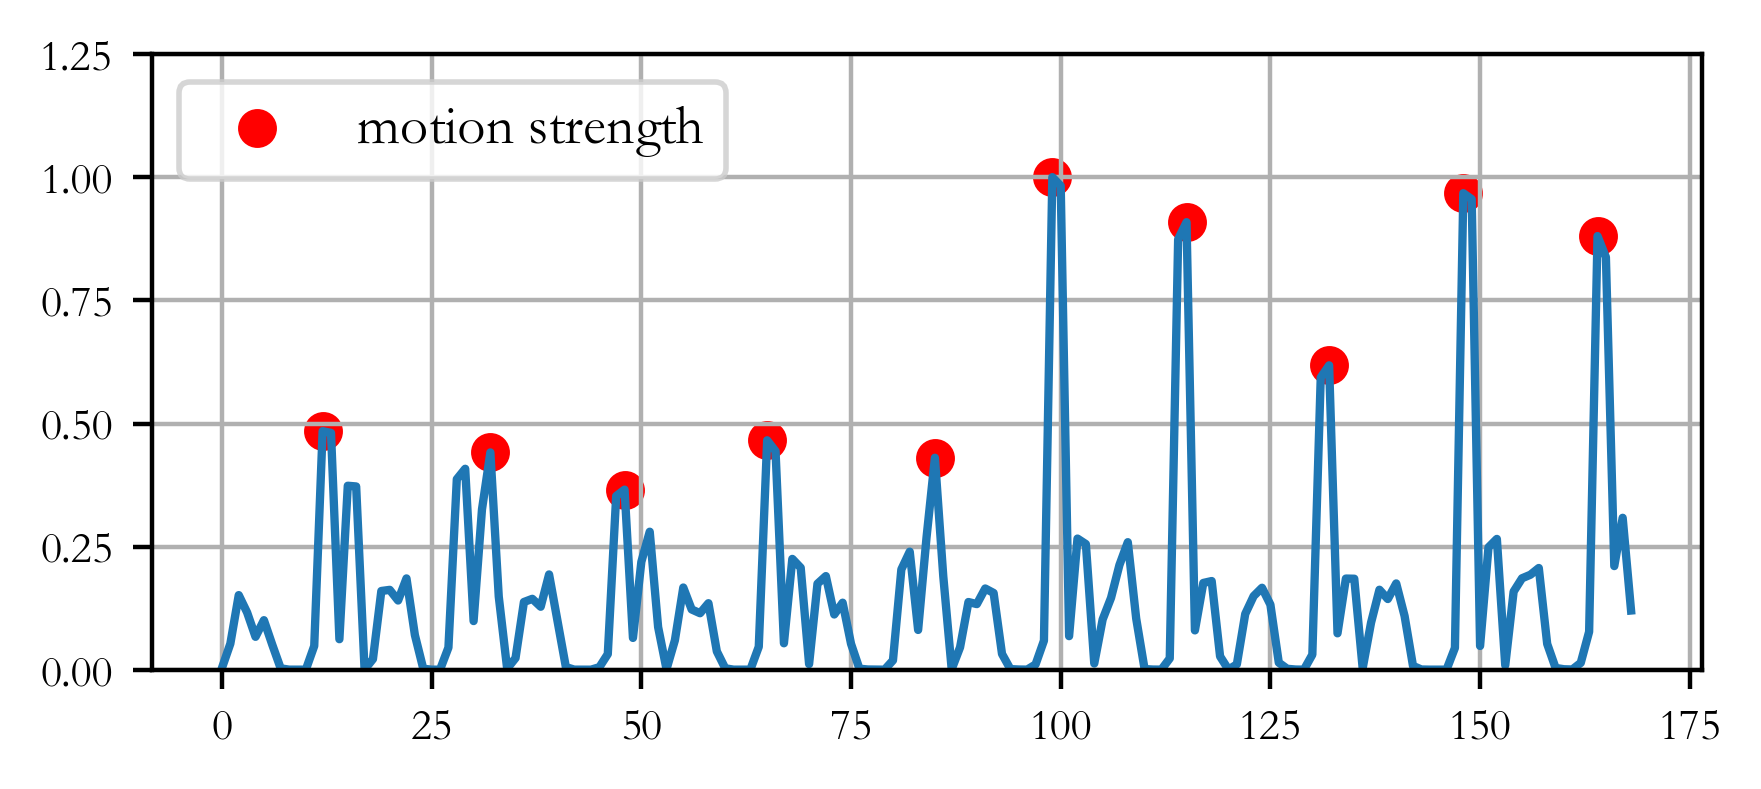

In [50]:
peak1, _ = find_peaks(d_new, height=0.3, distance=len(d_new)//20)

plt.rcParams['figure.figsize'] = [5, 2]
plt.ylim(0, 1.25)
plt.plot(d_new)
plt.scatter(peak1, d_new[peak1], color='red', label='motion strength')
plt.legend(loc='upper left')
plt.tick_params(labelsize=8)
plt.grid()

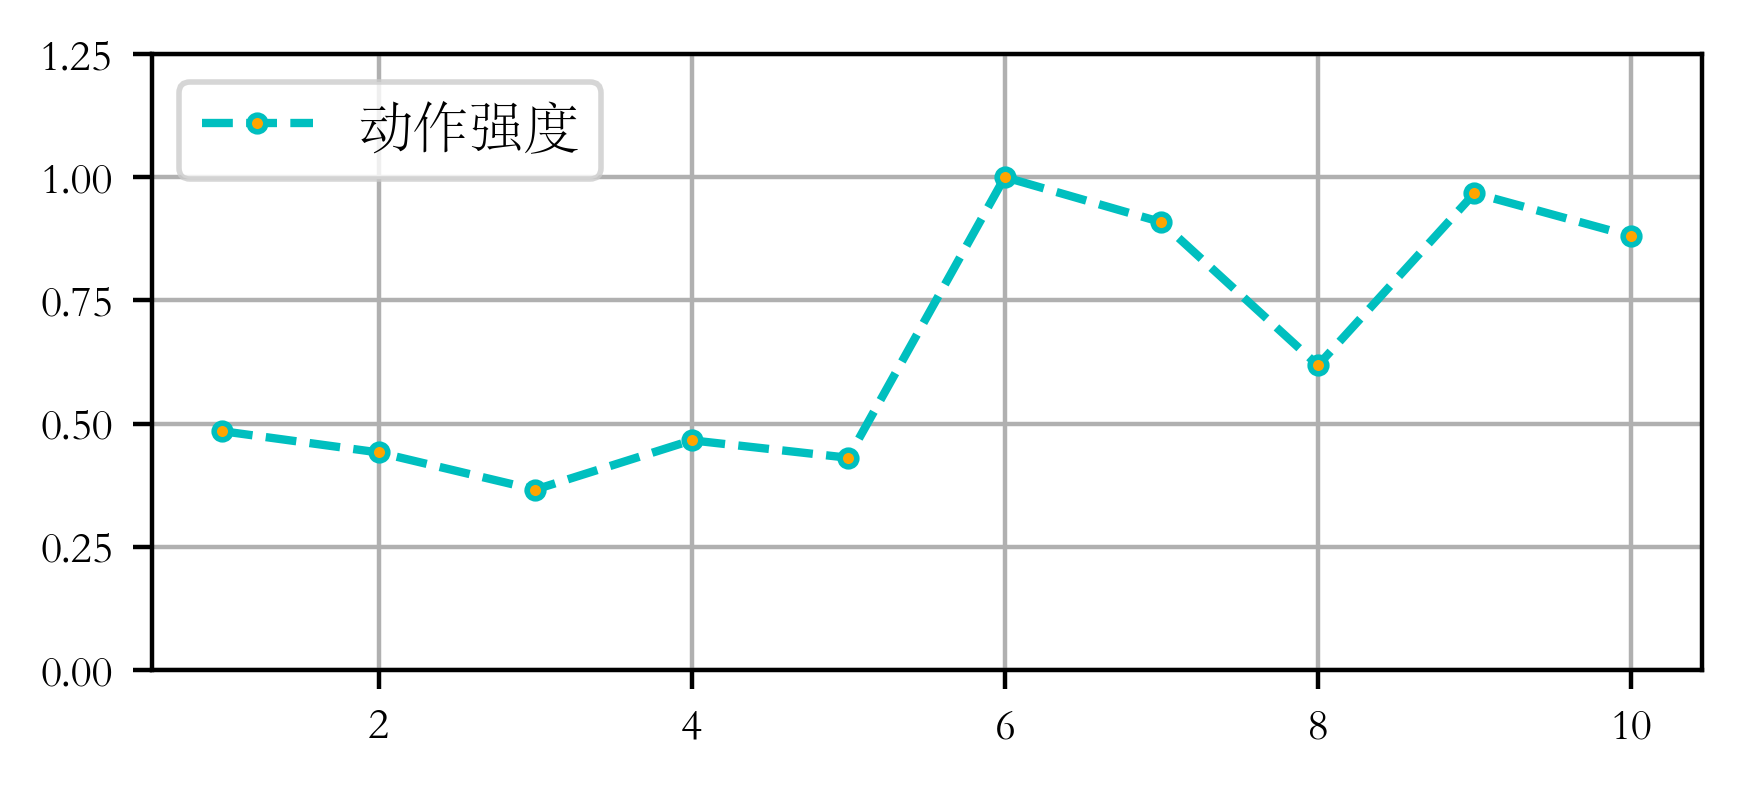

In [51]:
x_list = range(1, 11)

plt.ylim(0, 1.25)
plt.plot(x_list, d_new[peak1], label='动作强度', marker='.', mfc='orange', color='c', ls='--')
plt.legend(loc='upper left')
plt.tick_params(labelsize=8)
plt.grid()

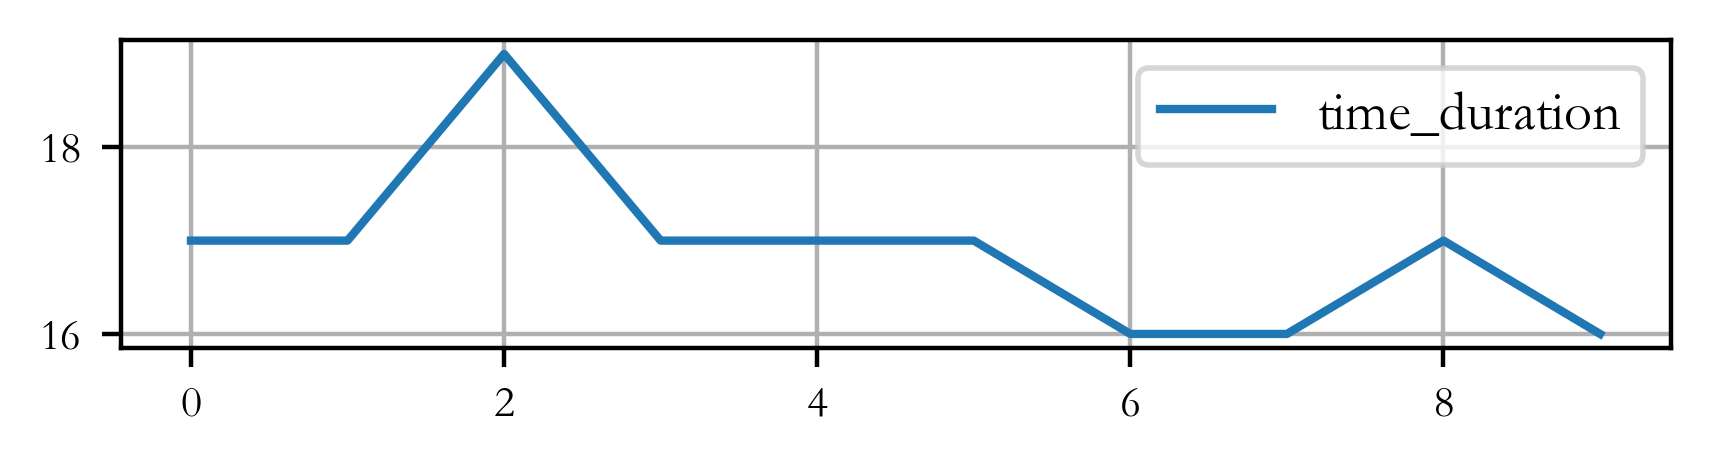

In [143]:
plt.rcParams['figure.figsize'] = [5, 1]
plt.grid()
plt.tick_params(labelsize=8)
plt.plot(period_list, label='time_duration')
plt.legend()

In [52]:
motion_strength = d_new[peak1]
time_period = period_list

baseline_MS = (motion_strength[0] + motion_strength[1]) / 2
baseline_TP = (period_list[0] + period_list[1]) / 2

baseline_MS, baseline_TP

(0.4629692891849496, 17.0)

In [57]:
len(motion_strength), len(time_period)

(10, 10)

In [63]:
# 原点坐标
origin_x = baseline_TP
origin_y = baseline_MS

motion_strength_list = []
time_period_list = []

for index, value in enumerate(time_period):
    # print(index, value)
    motion_strength_list.append((motion_strength[index]-origin_y)/origin_y)
    time_period_list.append((value-origin_x)/origin_x)

In [84]:
print(motion_strength_list)
print(time_period_list)

[0.04666353062294628, -0.0466635306229464, -0.2097533410342696, 0.006465016433160816, -0.07001696261930737, 1.1599704847820138, 0.9625688605813542, 0.33509943045927776, 1.089579029230296, 0.9016448719103883]
[0.0, 0.0, 0.11764705882352941, 0.0, 0.0, 0.0, -0.058823529411764705, -0.058823529411764705, 0.0, -0.058823529411764705]


Text(0, 0.5, 'MS deviation from the baseline')

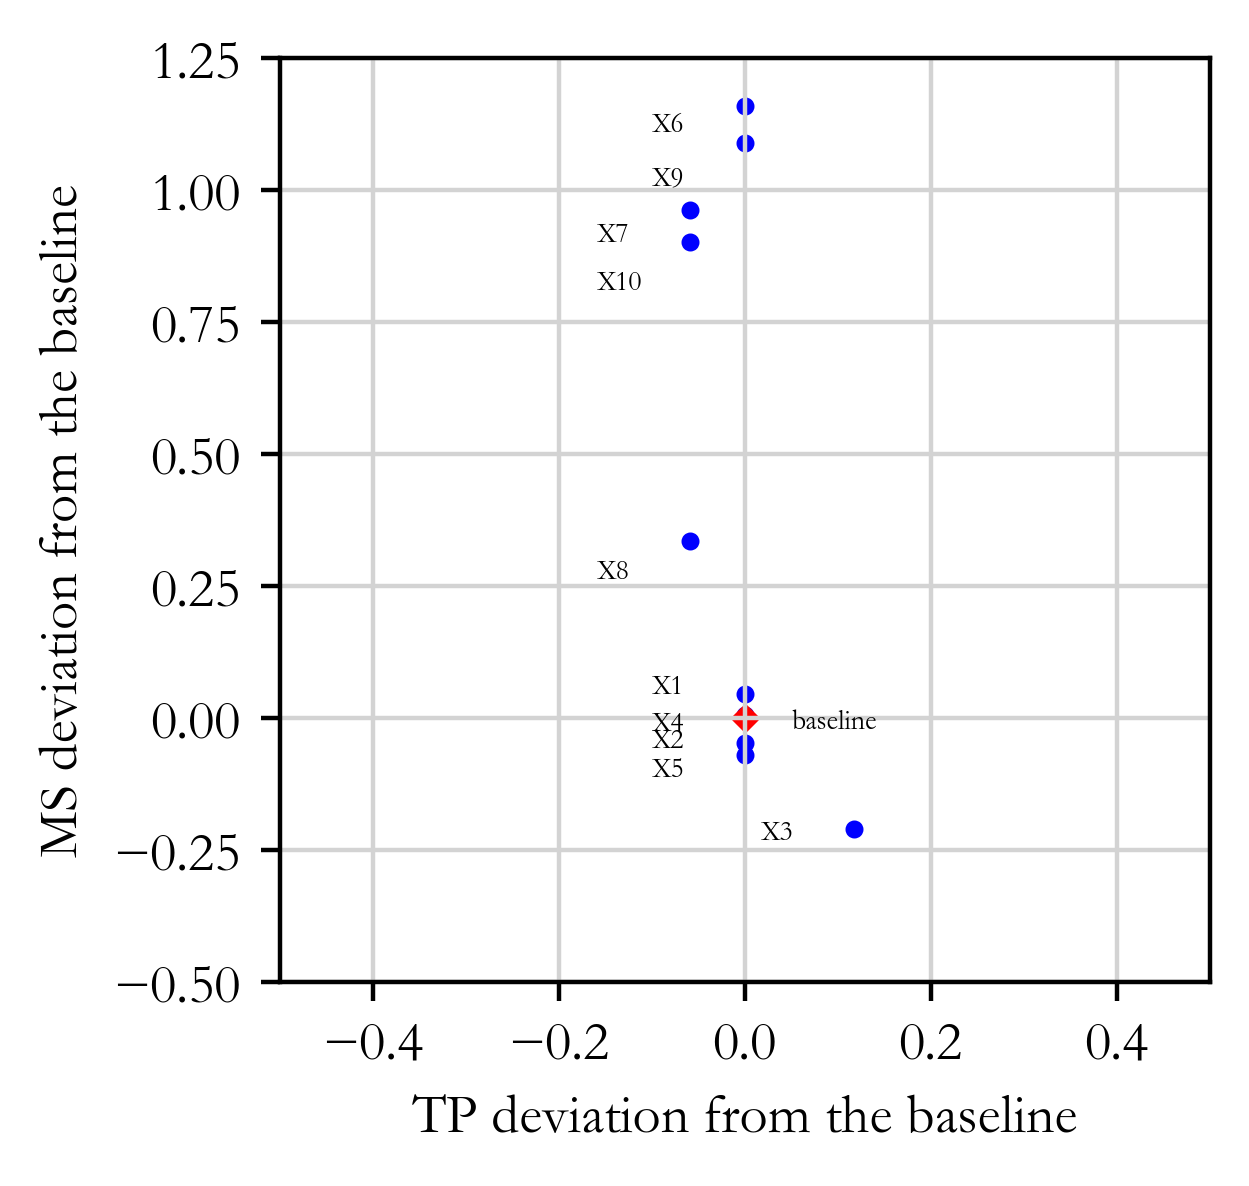

In [150]:
plt.rcParams['figure.figsize'] = [3, 3]
plt.grid(c='lightgrey')
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 1.25)
plt.scatter(time_period_list, motion_strength_list, marker='o', s=5, c='blue', label='score')
plt.scatter(0, 0, marker='D', s=8, c='red', label='baseline')
for i in range(len(time_period_list)):
    plt.annotate('X'+str(i+1), xy = (time_period_list[i], motion_strength_list[i]), 
    xytext = (time_period_list[i]-0.1, motion_strength_list[i]-0.01*i), size=5) # xy是需要标记的坐标，xytext是对应的标签坐标
plt.annotate('baseline', xy = (0, 0), 
xytext = (0+0.05, 0-0.02), size=5)
plt.xlabel('TP deviation from the baseline')
plt.ylabel('MS deviation from the baseline')
# plt.legend()

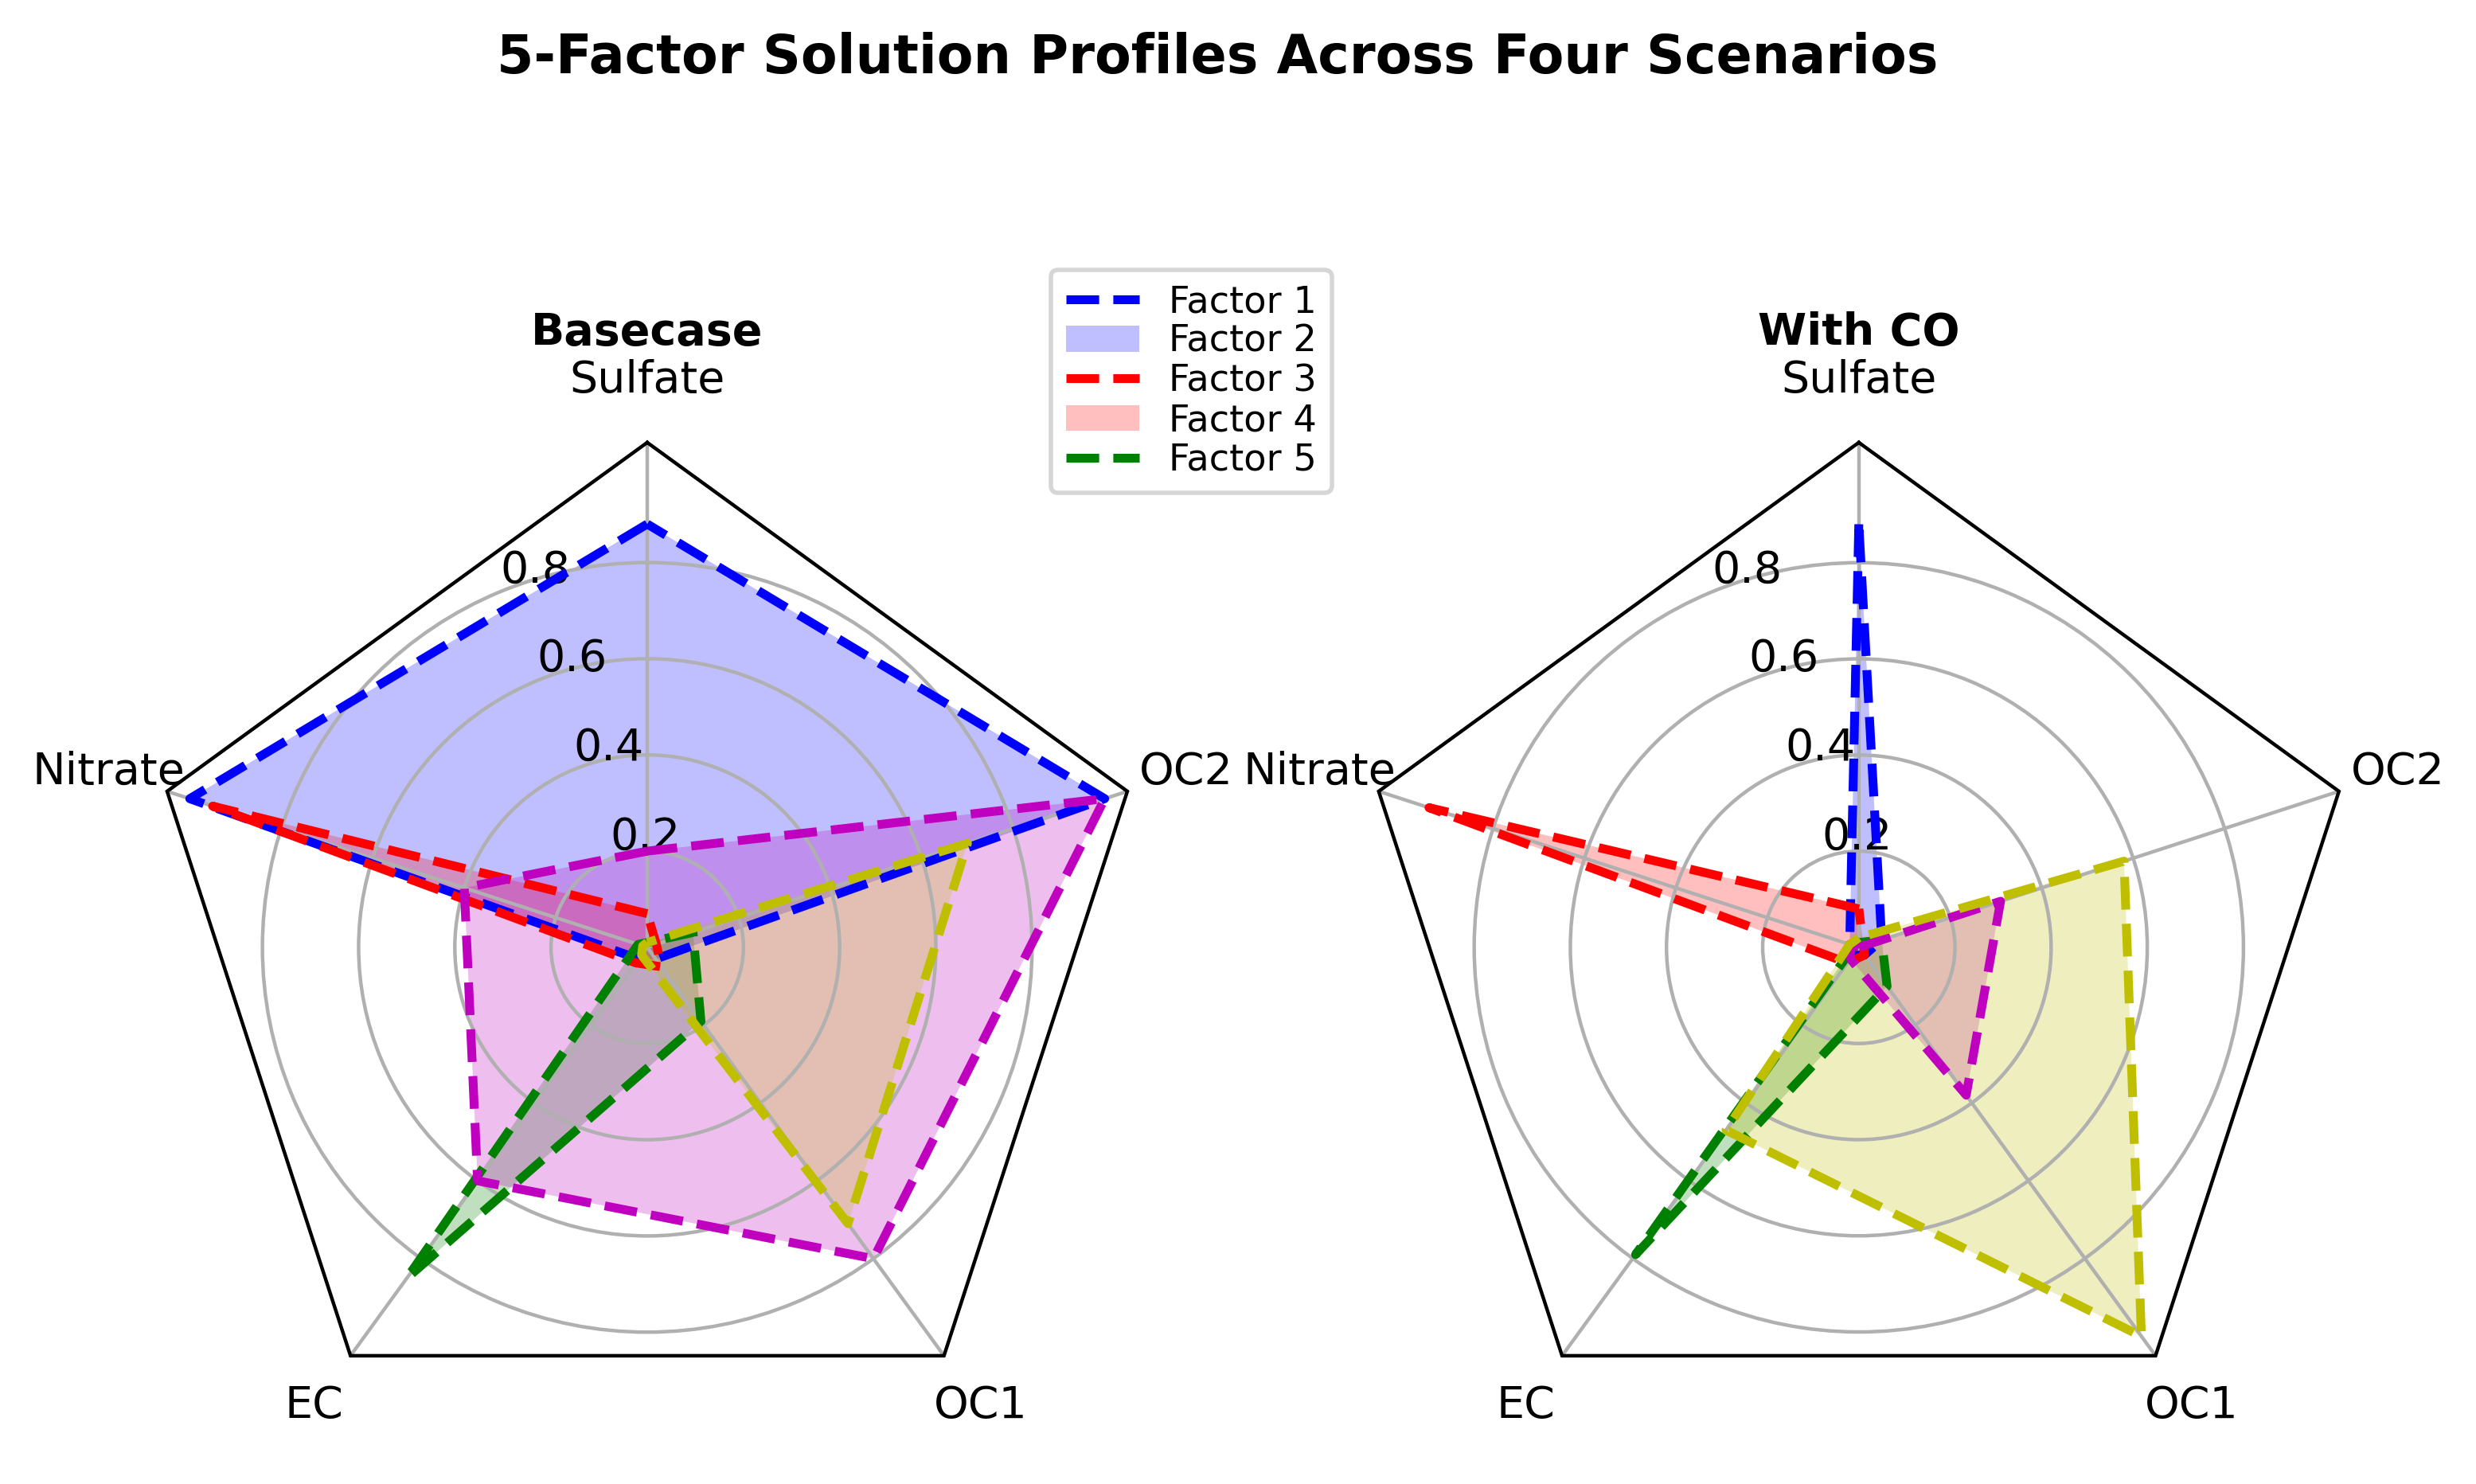

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
plt.rcParams["figure.dpi"] = 400 # 设置分辨率

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.
    This function creates a RadarAxes projection and registers it.
    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.
    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)#角度(弧度制)
    def draw_poly_patch(self):
        # rotate theta such that the first axis is at the top
        verts = unit_poly_verts(theta + np.pi / 2)
        return plt.Polygon(verts, closed=True, edgecolor='k')
    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5) #画圆
        # return plt.patches.Polygon((0.5, 0.5), closed=True)
    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)
    class RadarAxes(PolarAxes):
        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]
        def __init__(self, *args, **kwargs):
            super(RadarAxes, self).__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')
        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)
        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)
        def _close_line(self, line):#使曲线封闭，首尾相连
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)
        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)
        def _gen_axes_patch(self):
            return self.draw_patch()
        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.
            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta + np.pi / 2)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)
            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}
    register_projection(RadarAxes)
    return theta

def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.
    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts

def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See  doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['Sulfate', 'Nitrate', 'EC', 'OC1', 'OC2'],
        ('Basecase', [
            [0.88, 1, 0.03, 0.03, 1],
            [0.07, 0.95, 0.04, 0.05, 0.02],
            [0.01, 0.02, 0.85, 0.19, 0.10],
            [0.2, 0.4, 0.6, 0.8, 1],
            [0.01, 0.01, 0.02, 0.71, 0.70]]),
        ('With CO', [
            [0.88, 0.02, 0.02, 0.02, 0.05],
            [0.08, 0.94, 0.04, 0.02, 0.01],
            [0.01, 0.01, 0.79, 0.10, 0.05],
            [0.00, 0.02, 0.03, 0.38, 0.31],
            [0.02, 0.02, 0.47, 1, 0.58]]),
        # ('With O3', [
        #     [0.89, 0.01, 0.07, 0.00, 0.00, 0.05, 0.00, 0.00, 0.03],
        #     [0.07, 0.95, 0.05, 0.04, 0.00, 0.02, 0.12, 0.00, 0.00],
        #     [0.01, 0.02, 0.86, 0.27, 0.16, 0.19, 0.00, 0.00, 0.00],
        #     [0.01, 0.03, 0.00, 0.32, 0.29, 0.27, 0.00, 0.00, 0.95],
        #     [0.02, 0.00, 0.03, 0.37, 0.56, 0.47, 0.87, 0.00, 0.00]]),
        # ('CO & O3', [
        #     [0.87, 0.01, 0.08, 0.00, 0.00, 0.04, 0.00, 0.00, 0.01],
        #     [0.09, 0.95, 0.02, 0.03, 0.00, 0.01, 0.13, 0.06, 0.00],
        #     [0.01, 0.02, 0.71, 0.24, 0.13, 0.16, 0.00, 0.50, 0.00],
        #     [0.01, 0.03, 0.00, 0.28, 0.24, 0.23, 0.00, 0.44, 0.88],
        #     [0.02, 0.00, 0.18, 0.45, 0.64, 0.55, 0.86, 0.00, 0.16]])
    ]
    return data

if __name__ == '__main__':
    N = 5
    theta = radar_factory(N, frame='polygon')
    # theta = radar_factory(N, frame='circle')
    data = example_data()
    spoke_labels = data.pop(0)
    # fig, axes = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
    #                          subplot_kw=dict(projection='radar'))
    fig, axes = plt.subplots(figsize=(9, 9), nrows=1, ncols=2,
                             subplot_kw=dict(projection='radar'))
    # fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
    colors = ['b', 'r', 'g', 'm', 'y']
    linestyles = ['--', ':']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flatten(), data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color, linestyle="--", linewidth=2) ##本质是在极坐标下画封闭曲线
            ax.fill(theta, d, facecolor=color, alpha=0.25)##填充
        ax.set_varlabels(spoke_labels)
    # add legend relative to top-left plot
    ax = axes[0]
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = ax.legend(labels, loc=(0.9, .95),
                       labelspacing=0.1, fontsize='small')
    fig.text(0.5, 0.8, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')
    plt.show()